In [1]:
# Import necessary libraries
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import librosa.display
import IPython.display as ipd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [25]:
# Reading Dataset
df1 = pd.read_excel('Healthy_data.xlsx')
df2 = pd.read_excel('Pathological_data.xlsx')
df = pd.concat([df1, df2], ignore_index=True)
df = df[df.Gender == 'm']  # Filtering for men's voice samples
df.head(10)

,Recording Id,Type,Gender,Age,Diagnosis Notes,Pathology,Audio
3,4,n,m,22,Normal,Normal,4-a_n.wav
4,5,n,m,22,Normal,Normal,5-a_n.wav
10,9,n,m,25,Normal,Normal,9-a_n.wav
13,11,n,m,23,Normal,Normal,11-a_n.wav
17,15,n,m,24,Normal,Normal,15-a_n.wav
29,29,n,m,58,Normal,Normal,29-a_n.wav
32,32,n,m,45,Normal,Normal,32-a_n.wav
41,40,n,m,20,Normal,Normal,40-a_n.wav
42,41,n,m,20,Normal,Normal,41-a_n.wav
44,43,n,m,32,Normal,Normal,43-a_n.wav


In [26]:
# Dataset exploration
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (561, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 561 entries, 3 to 1358
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Recording Id     561 non-null    int64 
 1   Type             561 non-null    object
 2   Gender           561 non-null    object
 3   Age              561 non-null    int64 
 4   Diagnosis Notes  534 non-null    object
 5   Pathology        561 non-null    object
 6   Audio            561 non-null    object
dtypes: int64(2), object(5)
memory usage: 35.1+ KB


In [27]:
# Visualizing dataset distribution
type_gender_count = df.groupby(["Type", "Gender"])[['Audio']].count()
type_gender_count

,,Audio
Type,Gender,
n,m,259
p,m,302


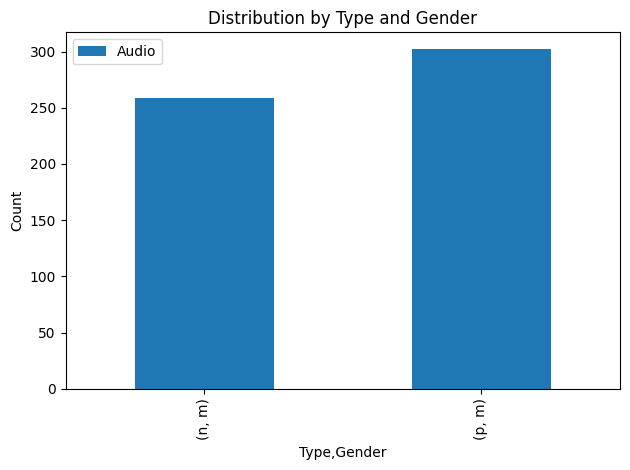

In [28]:
# Plot the distribution
type_gender_count.plot.bar()
plt.title('Distribution by Type and Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

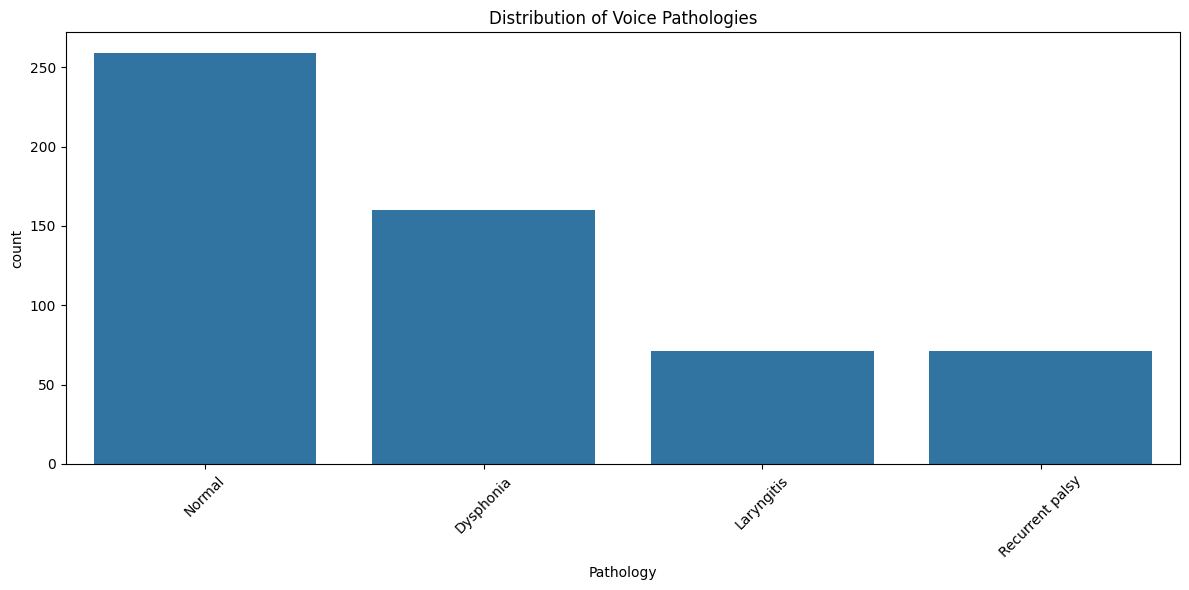

In [29]:
# Visualize pathology distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=df["Pathology"])
plt.title('Distribution of Voice Pathologies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# Define feature extraction function for MFCC features
audio_dataset_path = 'Filtered_Audio_Dataset/'

def features_extraction(file_name):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80) 
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [31]:
# Extract features from all audio files
extracted_features = []
for index_num, row in tqdm(df.iterrows(), total=df.shape[0]):
    file_name = audio_dataset_path + row["Audio"]
    final_class_labels = row["Pathology"]
    data = features_extraction(file_name)
    extracted_features.append([data, final_class_labels])

# Create dataframe of extracted features
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head(10)

100%|██████████| 561/561 [00:02<00:00, 190.03it/s]


,feature,class
0,"[-279.40063, 208.50458, -43.034977, -5.3609724...",Normal
1,"[-172.24774, 175.08725, -75.93269, 8.991032, -...",Normal
2,"[-160.34766, 238.37305, -50.651234, -8.168699,...",Normal
3,"[-174.26555, 202.435, -48.8887, 26.138357, -21...",Normal
4,"[-178.27687, 191.5492, -72.104416, 7.8393016, ...",Normal
5,"[-197.2665, 189.61102, -47.135727, 9.000774, -...",Normal
6,"[-228.07173, 183.02597, -31.62691, -15.123821,...",Normal
7,"[-235.79805, 207.87103, -39.370476, -27.216578...",Normal
8,"[-332.56256, 205.95407, -61.052193, 7.679651, ...",Normal
9,"[-147.25774, 178.20045, -82.12582, 1.978154, -...",Normal


In [32]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(extracted_features_df['class'])
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

# Prepare feature matrix
X = np.array(extracted_features_df['feature'].tolist())
y = y_encoded

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Class mapping: {'Dysphonia': np.int64(0), 'Laryngitis': np.int64(1), 'Normal': np.int64(2), 'Recurrent palsy': np.int64(3)}
X shape: (561, 80)
y shape: (561,)


In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.2, 
                                                    random_state=0)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (448, 80)
Testing set: (113, 80)


In [34]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Train SVM model
print("Training SVM model...")
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train)

Training SVM model...


SVC(probability=True)

In [36]:
# Evaluate model
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                           target_names=le.classes_))

Accuracy: 0.5929

Classification Report:
                 precision    recall  f1-score   support

      Dysphonia       0.57      0.50      0.53        32
     Laryngitis       0.00      0.00      0.00        15
         Normal       0.59      0.92      0.72        52
Recurrent palsy       1.00      0.21      0.35        14

       accuracy                           0.59       113
      macro avg       0.54      0.41      0.40       113
   weighted avg       0.56      0.59      0.53       113



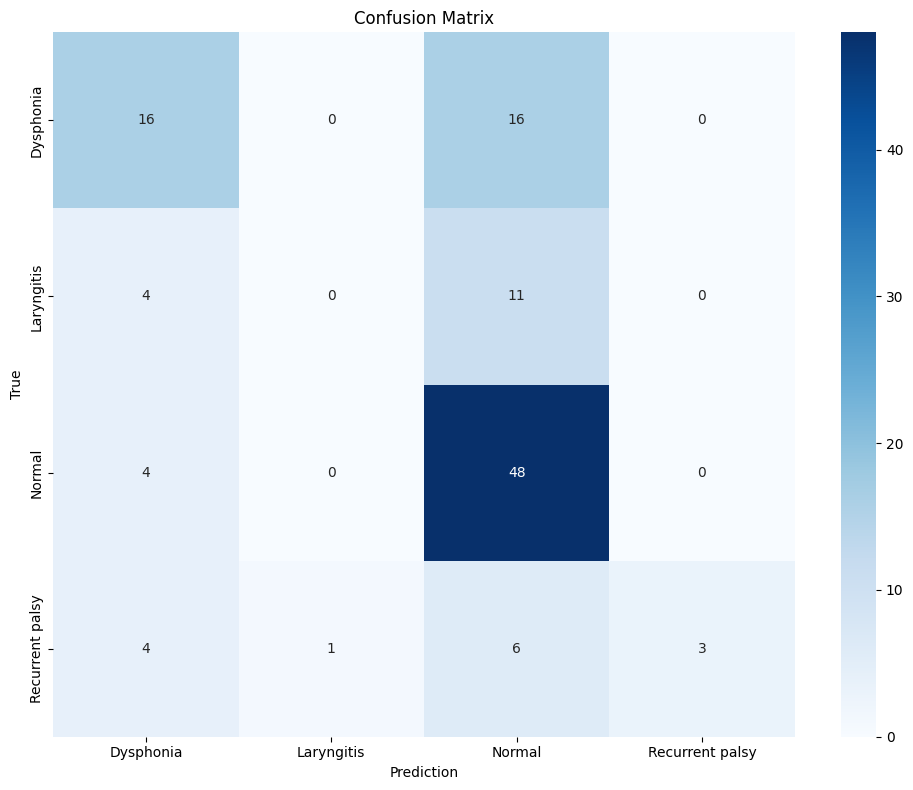

In [37]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [38]:
# Hyperparameter tuning with Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

print("Starting Grid Search for optimal hyperparameters...")
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Starting Grid Search for optimal hyperparameters...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.5579


In [39]:
# Train optimal SVM model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_scaled, y_train)

# Evaluate optimal model
y_pred_best = best_svm_model.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy with optimal model: {accuracy_best:.4f}")

# Classification report for optimal model
print("\nClassification Report (Optimal Model):")
print(classification_report(y_test, y_pred_best, 
                           target_names=le.classes_))

Accuracy with optimal model: 0.5929

Classification Report (Optimal Model):
                 precision    recall  f1-score   support

      Dysphonia       0.57      0.50      0.53        32
     Laryngitis       0.00      0.00      0.00        15
         Normal       0.59      0.92      0.72        52
Recurrent palsy       1.00      0.21      0.35        14

       accuracy                           0.59       113
      macro avg       0.54      0.41      0.40       113
   weighted avg       0.56      0.59      0.53       113



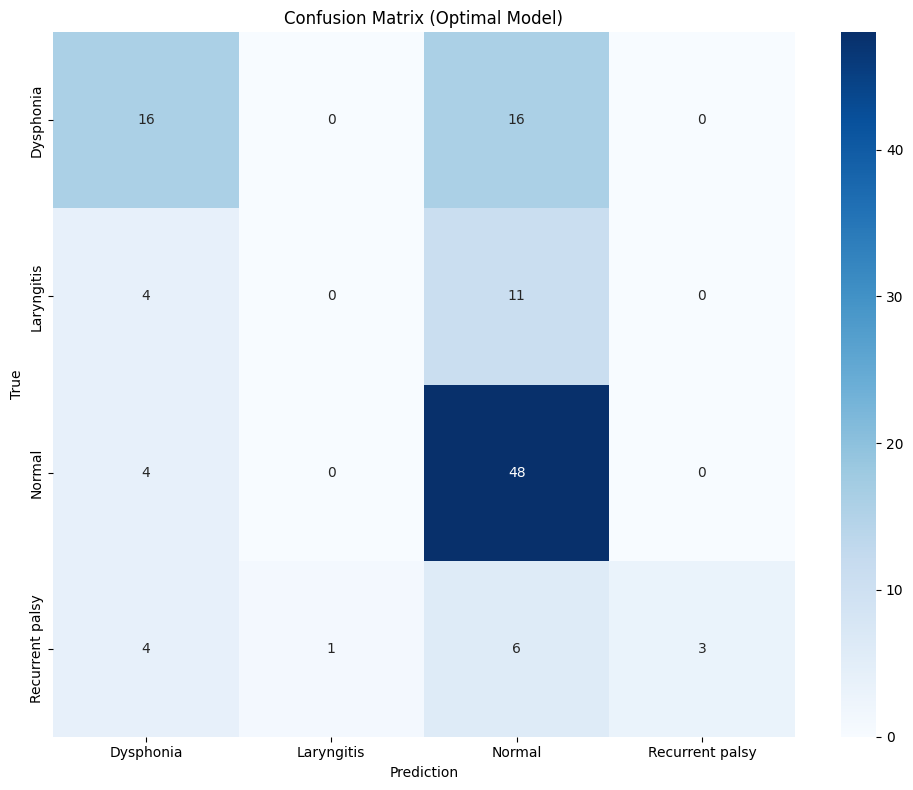

In [40]:
# Confusion Matrix for optimal model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix (Optimal Model)')
plt.tight_layout()
plt.show()

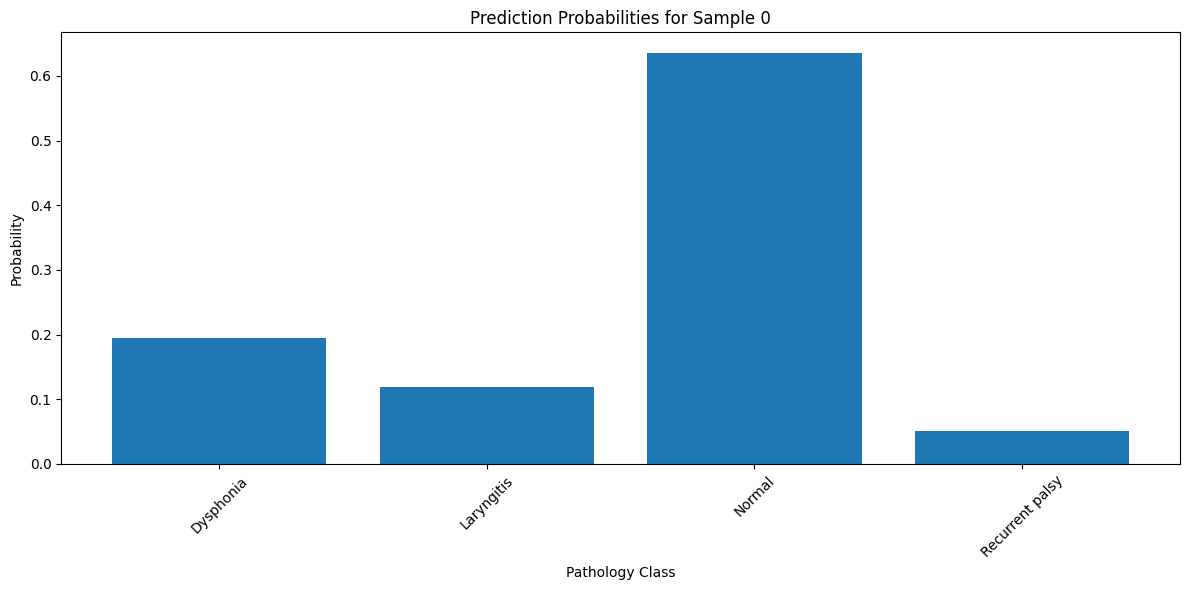

In [41]:
# Get prediction probabilities
prediction_probs = best_svm_model.predict_proba(X_test_scaled)

# Plot prediction probabilities for a sample
sample_idx = 0  # You can change this to view different samples
plt.figure(figsize=(12, 6))
plt.bar(le.classes_, prediction_probs[sample_idx])
plt.title(f'Prediction Probabilities for Sample {sample_idx}')
plt.xlabel('Pathology Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Save the model and scaler
import joblib
joblib.dump(best_svm_model, 'voice_pathology_svm_model.pkl')
joblib.dump(scaler, 'voice_pathology_scaler.pkl')
joblib.dump(le, 'voice_pathology_label_encoder.pkl')

['voice_pathology_label_encoder.pkl']

In [43]:
# Example of making prediction on a new file
def predict_pathology(file_path):
    # Extract features
    features = features_extraction(file_path)
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    # Make prediction
    prediction = best_svm_model.predict(features_scaled)
    prediction_proba = best_svm_model.predict_proba(features_scaled)
    
    # Get predicted class name
    predicted_class = le.inverse_transform(prediction)[0]
    
    # Display results
    print(f"Predicted pathology: {predicted_class}")
    
    # Show probabilities for all classes
    plt.figure(figsize=(12, 6))
    plt.bar(le.classes_, prediction_proba[0])
    plt.title(f'Prediction Probabilities for {os.path.basename(file_path)}')
    plt.xlabel('Pathology Class')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predicted_class, prediction_proba

Predicted pathology: Normal


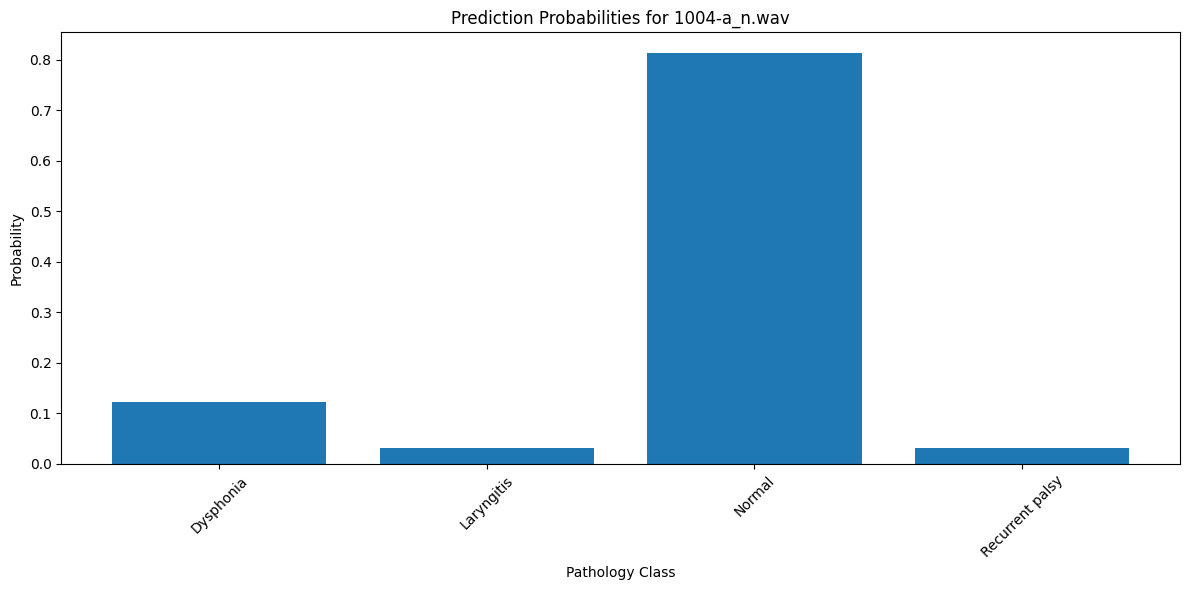

In [44]:
# Test prediction function on a sample
test_file = 'Male_Female_Healthy_Dataset/1004-a_n.wav'
predicted_class, probabilities = predict_pathology(test_file)

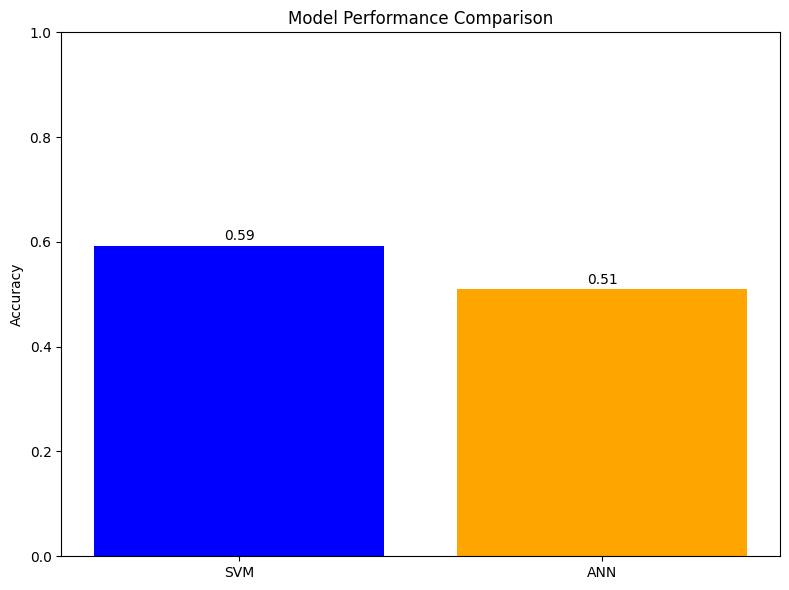

In [45]:
# Compare SVM performance with ANN performance
# Create performance comparison visualization if you have ANN results
# This is a placeholder - you would need to have saved your ANN results
try:
    ann_accuracy = 0.51  # Replace with your actual ANN accuracy
    models = ['SVM', 'ANN']
    accuracies = [accuracy_best, ann_accuracy]
    
    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.ylim(0, 1.0)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
    plt.title('Model Performance Comparison')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
except:
    print("No ANN results available for comparison")